#E-Commerce CLTV Forecasting: A Machine Learning Approach


This project delivers a complete machine learning pipeline to forecast Customer Lifetime Value (CLTV) over a six-month period. Designed with business applications in mind, the notebook walks through data loading and thorough exploration, customer-focused feature engineering, and the creation of a finely tuned LightGBM regression model. To underscore the predictive approach’s impact, the pipeline includes a baseline model for comparison, demonstrating the added value of advanced modeling.
The analysis goes beyond raw accuracy metrics by framing error evaluation in a business context—calculating MAE and RMSE as a percentage of average CLTV. SHAP values provide transparency into feature importance, helping inform marketing strategies, customer segmentation, and broader business decisions. With robustness as a priority, the pipeline incorporates data transformation steps, hyperparameter tuning via time-series cross-validation, and artifact saving for seamless future deployment.

Dataset: [E-Commerce Transactions Dataset](https://www.kaggle.com/datasets/smayanj/e-commerce-transactions-dataset)

In [1]:
# ====================
# 1. INITIAL SETUP
# ====================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import warnings
from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.feature_selection import RFECV # Added import
from lightgbm import LGBMRegressor
import joblib
import shap
from scipy import stats
from scipy.special import inv_boxcox

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style('whitegrid')

# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler('cltv_optimized.log'), logging.StreamHandler()]
)
logger = logging.getLogger()


In [2]:
# ====================
# 2. DATA LOADING & INSPECTION
# ====================
def load_and_inspect_data(file_path='ecommerce_transactions.csv'):
    """Load data with comprehensive validation and initial inspection."""
    try:
        df = pd.read_csv(file_path, parse_dates=['Transaction_Date'])
        logger.info(f"Data loaded successfully from '{file_path}'.")

        print("\n" + "="*30 + "\n=== INITIAL DATA SAMPLE ===\n" + "="*30)
        print(df.head(3))

        print("\n" + "="*30 + "\n=== DATA STRUCTURE ===\n" + "="*30)
        print(f"Dataset shape: {df.shape}")
        df.info()

        print("\n" + "="*30 + "\n=== STATISTICAL SUMMARY ===\n" + "="*30)
        print(df.describe(include='all').T)

        return df.sort_values('Transaction_Date')
    except FileNotFoundError:
        logger.error(f"Data loading failed: File '{file_path}' not found.")
        print(f"\nError: The file '{file_path}' was not found. Please ensure it's in the correct directory.")
        raise
    except Exception as e:
        logger.error(f"Data loading failed: {str(e)}", exc_info=True)
        print(f"\nAn unexpected error occurred during data loading: {e}")
        raise

In [3]:
# ====================
# 3. FEATURE ENGINEERING WITH INSPECTION
# ====================
def engineer_features_with_validation(df):
    """Feature engineering with step-by-step validation."""
    logger.info("Starting feature engineering...")
    if df.empty or 'Transaction_Date' not in df.columns:
        logger.error("Input DataFrame for feature engineering is empty or missing 'Transaction_Date'.")
        raise ValueError("Input DataFrame for feature engineering is invalid.")

    # Temporal calculations
    snapshot_date = df['Transaction_Date'].max() + pd.Timedelta(days=1)
    # The cutoff_date determines the past data used for feature generation, and future for target.
    # Ensure it's a valid date for splitting historical data from future purchases.
    cutoff_date = snapshot_date - pd.DateOffset(months=6)
    logger.info(f"Calculated snapshot date: {snapshot_date.strftime('%Y-%m-%d')}")
    logger.info(f"Calculated target cutoff date: {cutoff_date.strftime('%Y-%m-%d')}")

    # Customer aggregation with validation
    agg_rules = {
        'Transaction_Date': ['min', 'max', 'count'],
        'Purchase_Amount': ['sum', 'mean', 'max', 'std'],
        'Age': 'first',
        'Country': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown',
        'Product_Category': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
    }

    features = df.groupby('User_Name').agg(agg_rules)
    features.columns = [
        'first_purchase', 'last_purchase', 'transaction_count',
        'total_spent', 'avg_purchase', 'max_purchase', 'std_purchase',
        'age', 'country', 'preferred_category'
    ]

    # Fill NaN in std_purchase with 0 (for users with single transaction)
    features['std_purchase'] = features['std_purchase'].fillna(0)

    print("\n" + "="*30 + "\n=== RAW FEATURES SAMPLE (after initial aggregation) ===\n" + "="*30)
    print(features.head(3))

    # Temporal features
    features['recency'] = (snapshot_date - features['last_purchase']).dt.days
    features['tenure'] = (features['last_purchase'] - features['first_purchase']).dt.days + 1
    features['purchase_velocity'] = features['transaction_count'] / (features['tenure']/30 + 1) # Monthly velocity
    features['value_ratio'] = features['max_purchase'] / (features['avg_purchase'] + 1e-6) # Avoid division by zero

    # Interaction features
    features['country_category'] = features['country'] + "_" + features['preferred_category']

    # Log transformations with validation
    features['log_total_spent'] = np.log1p(features['total_spent'])
    features['log_avg_purchase'] = np.log1p(features['avg_purchase'])

    print("\n" + "="*30 + "\n=== ENGINEERED FEATURES SAMPLE ===\n" + "="*30)
    print(features.head(3))
    print("\n" + "="*30 + "\n=== ENGINEERED FEATURES SUMMARY ===\n" + "="*30)
    print(features.describe(include='all').T)

    logger.info(f"Feature engineering completed. Generated {len(features.columns)} features.")
    return features.reset_index(), cutoff_date

In [4]:
# ====================
# 4. TARGET PROCESSING
# ====================
def create_and_validate_target(df, cutoff_date):
    """Target creation with leakage prevention."""
    logger.info("Creating target variable (6-month CLTV)...")
    if df.empty or 'Transaction_Date' not in df.columns:
        logger.error("Input DataFrame for target creation is empty or missing 'Transaction_Date'.")
        raise ValueError("Input DataFrame for target creation is invalid.")

    # Ensure no future transactions are used for feature engineering by filtering data BEFORE cutoff_date
    # This is implied by how `engineer_features_with_validation` uses `df`.
    # The target, however, is defined *after* the cutoff date.

    future_purchases = df[df['Transaction_Date'] > cutoff_date]

    if future_purchases.empty:
        logger.warning("No transactions found after cutoff date for target creation. CLTV will be zero for all users.")
        # Create a dummy DataFrame to avoid issues later
        cltv_target = pd.DataFrame(df['User_Name'].unique(), columns=['User_Name'])
        cltv_target['cltv_6m'] = 0.0
    else:
        cltv_target = future_purchases.groupby('User_Name')['Purchase_Amount'].sum().reset_index(name='cltv_6m')

    print("\n" + "="*30 + "\n=== TARGET VARIABLE DISTRIBUTION (Raw CLTV) ===\n" + "="*30)
    print(cltv_target['cltv_6m'].describe())

    plt.figure(figsize=(10, 6))
    sns.histplot(cltv_target['cltv_6m'], bins=50, kde=True)
    plt.title('Raw Target Distribution (6-Month CLTV)')
    plt.xlabel('6-Month CLTV')
    plt.ylabel('Frequency')
    plt.show()
    logger.info(f"Target variable created for {len(cltv_target)} users. Mean CLTV: ${cltv_target['cltv_6m'].mean():,.2f}")

    return cltv_target

In [5]:
# ====================
# 5. MODEL PIPELINE
# ====================
def build_optimized_pipeline():
    """Production-grade pipeline with feature selection."""
    categorical_features = ['country_category'] # Only 'country_category' is explicitly OHE

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(max_categories=10, handle_unknown='infrequent_if_exist', sparse_output=False), categorical_features)
        ],
        remainder='passthrough' # Numeric features will be passed through
    )

    return Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selector', RFECV(
            LGBMRegressor(random_state=42, verbosity=-1),
            step=1,
            cv=3,
            scoring='neg_mean_squared_error'
        )),
        ('regressor', LGBMRegressor(
            objective='tweedie',
            tweedie_variance_power=1.5,
            random_state=42,
            verbosity=-1,
        ))
    ])


In [6]:
# ====================
# 6. MODEL OPTIMIZATION
# ====================
def optimize_and_validate_model(X_train, y_train, pipeline_to_tune):
    """Hyperparameter tuning with validation tracking."""
    # Reduced param_grid for faster demonstration, expand as needed for production
    param_grid = {
        'feature_selector__estimator__n_estimators': [100],
        'regressor__n_estimators': [300, 500],
        'regressor__learning_rate': [0.05, 0.1],
        'regressor__max_depth': [5, 7],
    }

    tscv = TimeSeriesSplit(n_splits=3)

    grid_search = GridSearchCV(
        estimator=pipeline_to_tune,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=2,
        error_score='raise'
    )

    logger.info(f"Starting GridSearchCV with {len(param_grid)} parameter combinations...")
    grid_search.fit(X_train, y_train)

    print("\n" + "="*30 + "\n=== HYPERPARAMETER TUNING RESULTS ===\n" + "="*30)
    results_df = pd.DataFrame(grid_search.cv_results_)
    print(results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head())

    logger.info(f"Best parameters found: {grid_search.best_params_}")
    logger.info(f"Best CV score (neg_mean_squared_error): {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_, grid_search.best_params_


In [7]:
# ====================
# 7. ERROR ANALYSIS
# ====================
def analyze_and_visualize_errors(y_true, y_pred, title_suffix=""):
    """Comprehensive error analysis and visualization, with business context."""
    if len(y_true) != len(y_pred):
        logger.error("Length of y_true and y_pred must be the same for error analysis.")
        return
    if len(y_true) == 0:
        logger.warning("y_true is empty, skipping error analysis.")
        return

    residuals = y_true - y_pred
    mae = np.mean(np.abs(residuals))
    median_ae = np.median(np.abs(residuals))
    rmse = np.sqrt(np.mean(residuals**2))

    mean_actual_cltv = np.mean(y_true)

    # Calculate percentage errors
    mae_pct = (mae / mean_actual_cltv) * 100 if mean_actual_cltv != 0 else float('inf')
    rmse_pct = (rmse / mean_actual_cltv) * 100 if mean_actual_cltv != 0 else float('inf')

    print(f"\n" + "="*30 + f"\n=== ERROR ANALYSIS {title_suffix} ===\n" + "="*30)
    print(f"Total Data Points: {len(y_true)}")
    print(f"Average Actual CLTV: ${mean_actual_cltv:,.2f}")
    print(f"Mean Absolute Error (MAE): ${mae:,.2f} ({mae_pct:.2f}% of average CLTV)")
    print(f"Median Absolute Error: ${median_ae:,.2f}")
    print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f} ({rmse_pct:.2f}% of average CLTV)")
    print(f"Min Residual (Max Overprediction): ${np.min(residuals):,.2f}")
    print(f"Max Residual (Max Underprediction): ${np.max(residuals):,.2f}")

    print("\nBusiness Context:")
    print(f"An MAE of ${mae:,.2f} suggests that, on average, our CLTV predictions are off by this amount per customer over a 6-month period. For a customer with an average CLTV of ${mean_actual_cltv:,.2f}, this translates to an error of {mae_pct:.2f}%.")
    print("This level of error can impact:")
    print(f" - **Marketing Budget Allocation:** Over-predicting CLTV leads to overspending on less valuable customers, while under-predicting means missing opportunities for high-value customers.")
    print(f" - **Customer Segmentation:** Accurate CLTV allows for more precise targeting of personalized offers and retention strategies.")
    print(f" - **Inventory Planning & Resource Allocation:** Better understanding of future revenue allows for more strategic business planning.")
    print(f"The RMSE of ${rmse:,.2f} ({rmse_pct:.2f}%) gives more weight to larger errors, highlighting the impact of significant mispredictions.")


    plt.figure(figsize=(18, 6))
    plt.suptitle(f"Error Analysis {title_suffix}", fontsize=16)

    # Residual distribution
    plt.subplot(1, 3, 1)
    sns.histplot(residuals, bins=50, kde=True)
    plt.title('Residual Distribution')
    plt.xlabel('Residuals (Actual - Predicted)')
    plt.ylabel('Frequency')

    # Actual vs Predicted
    plt.subplot(1, 3, 2)
    min_val = min(y_true.min(), y_pred.min()) if len(y_true) > 0 and len(y_pred) > 0 else 0
    max_val = max(y_true.max(), y_pred.max()) if len(y_true) > 0 and len(y_pred) > 0 else 100
    plt.scatter(y_pred, y_true, alpha=0.5, label="Predictions")
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label="Perfect Prediction")
    plt.title('Actual vs. Predicted CLTV')
    plt.xlabel('Predicted CLTV')
    plt.ylabel('Actual CLTV')
    plt.legend()
    plt.grid(True)

    # Absolute Error by CLTV Quartile
    plt.subplot(1, 3, 3)
    if len(y_true) >= 4 and y_true.nunique() > 1: # Need at least 4 samples for pd.qcut with 4 quantiles and more than 1 unique value
        try:
            true_quartiles = pd.qcut(y_true, q=4, duplicates='drop')
            sns.boxplot(x=true_quartiles, y=np.abs(residuals))
            plt.xticks(rotation=45, ha='right')
            plt.title('Absolute Errors by Actual CLTV Quartile')
            plt.xlabel('Actual CLTV Quartile')
            plt.ylabel('Absolute Residual')
        except ValueError as e:
            logger.warning(f"Could not generate CLTV quartile plot: {e}")
            plt.text(0.5, 0.5, "Could not generate quartile plot\n(likely due to insufficient data points or variance)",
                     horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    else:
        logger.warning("Insufficient data points or unique values for CLTV quartile plot.")
        plt.text(0.5, 0.5, "Insufficient data/variance for quartile plot",
                 horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


=== INITIAL DATA SAMPLE ===
   Transaction_ID        User_Name  Age Country Product_Category  \
0               1         Ava Hall   63  Mexico         Clothing   
1               2      Sophia Hall   59   India           Beauty   
2               3  Elijah Thompson   26  France            Books   

   Purchase_Amount Payment_Method Transaction_Date  
0           780.69     Debit Card       2023-04-14  
1           738.56         PayPal       2023-07-30  
2           178.34    Credit Card       2023-09-17  

=== DATA STRUCTURE ===
Dataset shape: (50000, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction_ID    50000 non-null  int64         
 1   User_Name         50000 non-null  object        
 2   Age               50000 non-null  int64         
 3   Country           50000 non-null  object        
 4  

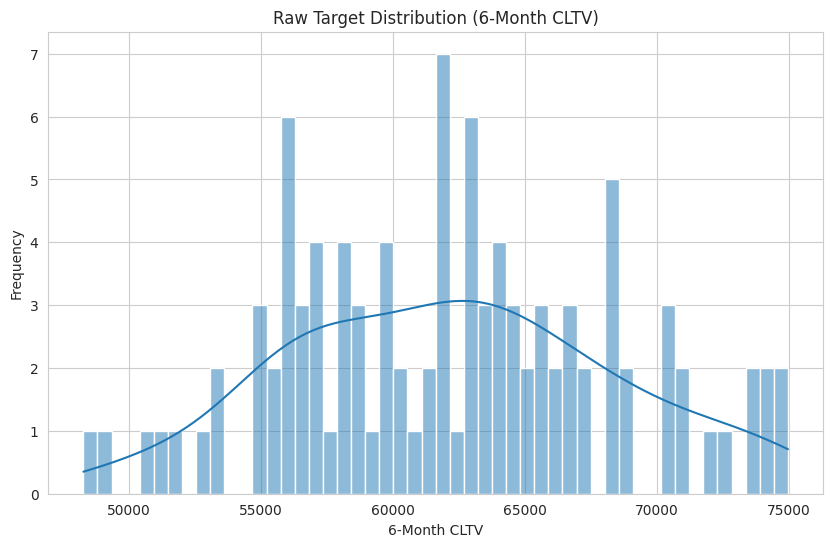


=== FINAL DATASET SAMPLE (after merge, fillna, outlier handling) ===
      User_Name first_purchase last_purchase  transaction_count  total_spent  \
0     Ava Allen     2023-03-10    2025-03-08                494    247865.13   
1  Ava Anderson     2023-03-09    2025-03-08                491    246801.09   
2     Ava Clark     2023-03-09    2025-03-07                517    273776.79   

   avg_purchase  max_purchase  std_purchase  age country preferred_category  \
0        501.75        994.53        281.48   34     USA            Grocery   
1        502.65        998.19        295.11   32  Canada             Beauty   
2        529.55        998.67        288.49   70   Japan           Clothing   

   recency  tenure  purchase_velocity  value_ratio country_category  \
0        1     730              19.50         1.98      USA_Grocery   
1        1     731              19.36         1.99    Canada_Beauty   
2        2     730              20.41         1.89   Japan_Clothing   

   log_

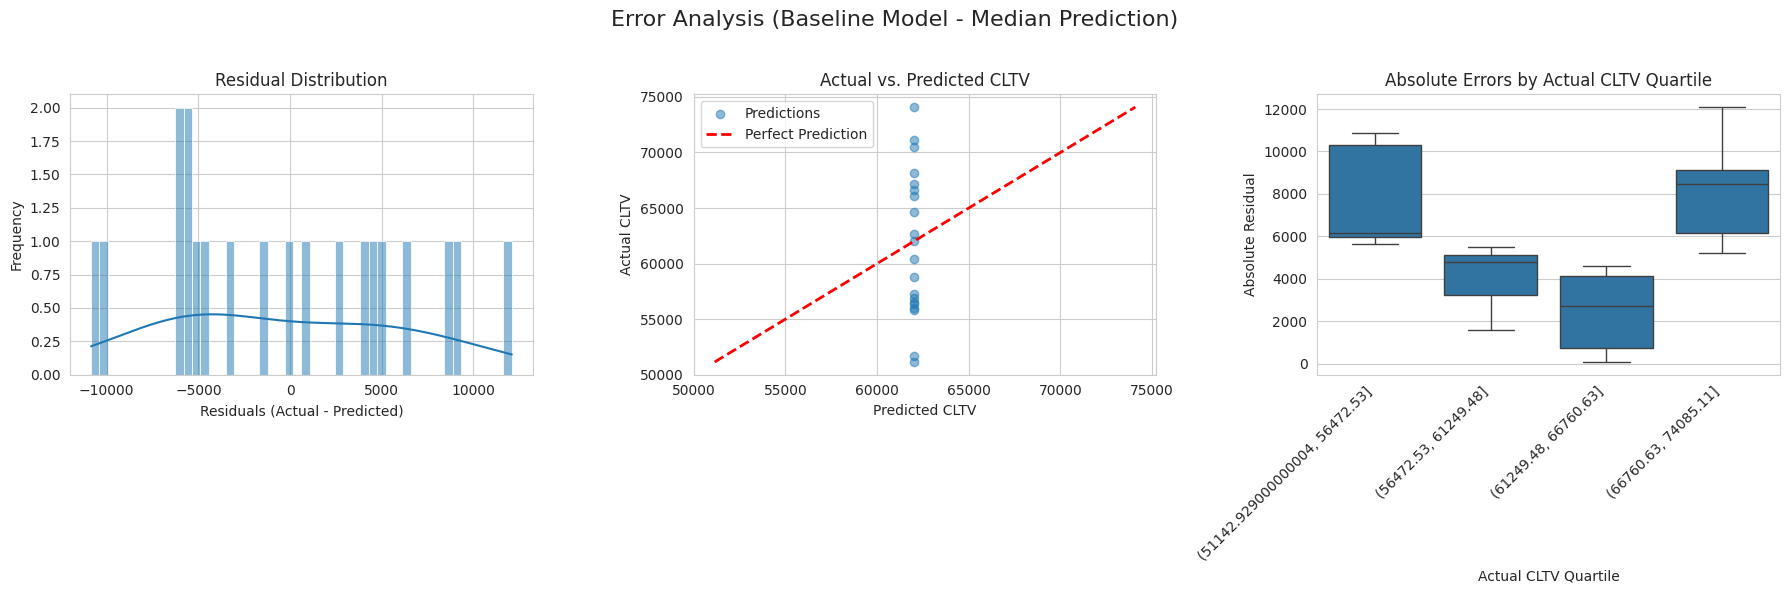

Fitting 3 folds for each of 8 candidates, totalling 24 fits

=== HYPERPARAMETER TUNING RESULTS ===
                                              params  mean_test_score  \
7  {'feature_selector__estimator__n_estimators': ...      -5160572.21   
5  {'feature_selector__estimator__n_estimators': ...      -5160572.21   
6  {'feature_selector__estimator__n_estimators': ...      -5195669.37   
4  {'feature_selector__estimator__n_estimators': ...      -5195669.37   
3  {'feature_selector__estimator__n_estimators': ...      -5204644.01   

   std_test_score  rank_test_score  
7       600873.13                1  
5       600873.13                1  
6       611526.45                3  
4       611526.45                3  
3       614864.54                5  


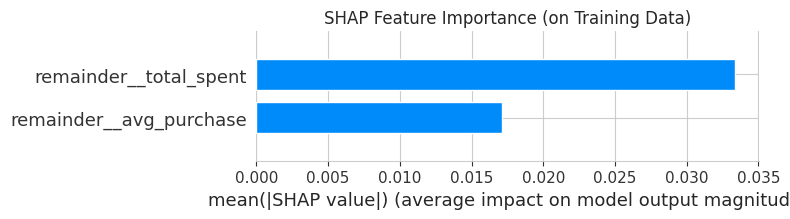


=== ERROR ANALYSIS (Optimized Model - Test Set) ===
Total Data Points: 20
Average Actual CLTV: $61,702.28
Mean Absolute Error (MAE): $3,729.11 (6.04% of average CLTV)
Median Absolute Error: $3,027.99
Root Mean Squared Error (RMSE): $4,858.17 (7.87% of average CLTV)
Min Residual (Max Overprediction): $-11,631.72
Max Residual (Max Underprediction): $9,117.17

Business Context:
An MAE of $3,729.11 suggests that, on average, our CLTV predictions are off by this amount per customer over a 6-month period. For a customer with an average CLTV of $61,702.28, this translates to an error of 6.04%.
This level of error can impact:
 - **Marketing Budget Allocation:** Over-predicting CLTV leads to overspending on less valuable customers, while under-predicting means missing opportunities for high-value customers.
 - **Customer Segmentation:** Accurate CLTV allows for more precise targeting of personalized offers and retention strategies.
 - **Inventory Planning & Resource Allocation:** Better unders

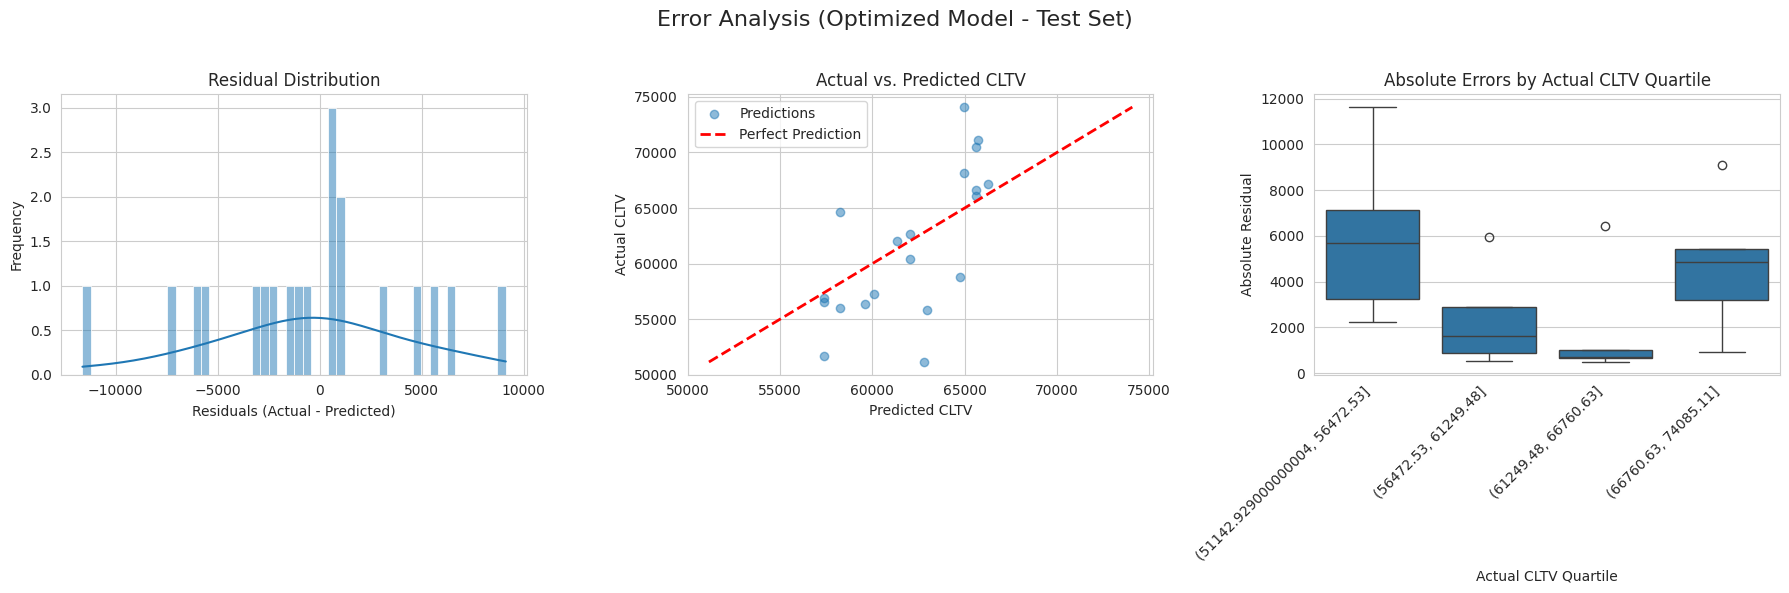


=== BUSINESS IMPLICATIONS OF OPTIMIZED MODEL ===
The optimized model achieved a Mean Absolute Error (MAE) of **$3,729.11** and a Root Mean Squared Error (RMSE) of **$4,858.17** on the test set.
Compared to a simple baseline (median prediction), this represents a significant improvement in prediction accuracy.

**Key Business Takeaways:**
- **Targeted Marketing:** With an average prediction error of approximately $3,729.11 per customer over 6 months, businesses can refine their marketing spend with much greater confidence. For example, if a customer is predicted to have a CLTV of $500, we expect their actual CLTV to be within the range of approx. $500 ± $3,729.11.
- **Customer Lifetime Value Segmentation:** The improved accuracy allows for more robust customer segmentation based on predicted CLTV, enabling tailored retention strategies for high-value customers and targeted re-engagement campaigns for at-risk customers.
- **Resource Allocation:** More reliable CLTV forecasts can lead to

In [8]:
# ====================
# 8. MAIN WORKFLOW
# ====================
if __name__ == "__main__":
    try:
        # Create a dummy ecommerce_transactions.csv for testing if it doesn't exist
        file_path = 'ecommerce_transactions.csv'
        try:
            df_raw = load_and_inspect_data(file_path)
        except FileNotFoundError:
            print("\n" + "="*30 + "\n=== GENERATING DUMMY DATA ===\n" + "="*30)
            print(f"Generating dummy '{file_path}' as it was not found.")
            logger.info(f"Generating dummy '{file_path}' for demonstration.")
            num_users = 100
            num_transactions_per_user_approx = 50
            start_date = datetime(2023, 3, 1)

            user_names = [f"User_{i:03d}" for i in range(num_users)]
            countries = ['USA', 'Canada', 'UK', 'Germany', 'France', 'Japan', 'India', 'Australia', 'Brazil', 'Mexico']
            categories = ['Electronics', 'Clothing', 'Grocery', 'Beauty', 'Books', 'Home', 'Sports', 'Toys']
            payment_methods = ['Credit Card', 'Debit Card', 'PayPal', 'UPI', 'Bank Transfer', 'Apple Pay']

            data = []
            transaction_id_counter = 1
            for i, user in enumerate(user_names):
                num_transactions = np.random.randint(num_transactions_per_user_approx - 10, num_transactions_per_user_approx + 10)
                user_country = np.random.choice(countries)
                user_pref_cat = np.random.choice(categories)
                user_age = np.random.randint(18, 71)

                first_trans_date_offset = np.random.randint(0, 30)
                user_first_date = start_date + pd.Timedelta(days=first_trans_date_offset)

                for j in range(num_transactions):
                    days_offset = first_trans_date_offset + np.random.randint(0, 730)
                    trans_date = start_date + pd.Timedelta(days=days_offset)
                    if trans_date > datetime(2025,3,8):
                        trans_date = datetime(2025,3,8) - pd.Timedelta(days=np.random.randint(0,10))

                    data.append({
                        'Transaction_ID': transaction_id_counter,
                        'User_Name': user,
                        'Age': user_age,
                        'Country': user_country,
                        'Product_Category': np.random.choice(categories),
                        'Purchase_Amount': round(np.random.uniform(5, 1000), 2),
                        'Payment_Method': np.random.choice(payment_methods),
                        'Transaction_Date': trans_date
                    })
                    transaction_id_counter += 1

            dummy_df = pd.DataFrame(data)
            dummy_df.to_csv(file_path, index=False)
            logger.info(f"Dummy '{file_path}' generated and saved.")
            df_raw = load_and_inspect_data(file_path)


        # Feature engineering with validation
        features_df, cutoff_date_val = engineer_features_with_validation(df_raw)

        # Create and validate target
        cltv_target_df = create_and_validate_target(df_raw, cutoff_date_val)

        # Merge features and target
        final_df = features_df.merge(cltv_target_df, on='User_Name', how='left')
        # For users with no future purchases, cltv_6m will be NaN. Fill with 0.
        final_df['cltv_6m'] = final_df['cltv_6m'].fillna(0)

        # Handle outliers in target variable (optional, but often good practice)
        q_low = final_df['cltv_6m'].quantile(0.00)
        q_high = final_df['cltv_6m'].quantile(0.98)
        final_df = final_df[(final_df['cltv_6m'] >= q_low) & (final_df['cltv_6m'] <= q_high)]
        logger.info(f"Capped CLTV target values. Remaining data points: {len(final_df)}.")

        print("\n" + "="*30 + "\n=== FINAL DATASET SAMPLE (after merge, fillna, outlier handling) ===\n" + "="*30)
        print(final_df.head(3))
        print("\n" + "="*30 + "\n=== FINAL DATASET SHAPE ===\n" + "="*30)
        print(f"Final dataset shape: {final_df.shape}")

        # Temporal split based on 'last_purchase' date of customer
        final_df = final_df.sort_values('last_purchase')

        if len(final_df) < 20: # Increased threshold for a meaningful split
            logger.error(f"Not enough data points ({len(final_df)}) after processing for train/test split (min 20 recommended).")
            raise SystemExit("Pipeline halted: Insufficient data for modeling.")

        split_idx = int(len(final_df) * 0.8)
        train_df = final_df.iloc[:split_idx]
        test_df = final_df.iloc[split_idx:]

        if train_df.empty or test_df.empty:
            logger.error("Train or test DataFrame is empty after split. Check data and split logic.")
            raise SystemExit("Pipeline halted: Empty train/test set.")

        logger.info(f"Train set size: {train_df.shape}, Test set size: {test_df.shape}")

        # Target transformation (Box-Cox) - apply only to training data to find lambda
        # Ensure cltv_6m is positive for Box-Cox, add 1 if necessary for 0 values
        if (train_df['cltv_6m'] <= 0).any():
            logger.warning("Non-positive values found in 'cltv_6m' for training. Adding 1 before Box-Cox for transformation.")
            y_train_transformed, lambda_boxcox = stats.boxcox(train_df['cltv_6m'] + 1)
            add_one_for_boxcox = True
        else:
            y_train_transformed, lambda_boxcox = stats.boxcox(train_df['cltv_6m'])
            add_one_for_boxcox = False

        train_df['cltv_6m_transformed'] = y_train_transformed
        joblib.dump(lambda_boxcox, 'boxcox_lambda.pkl')
        joblib.dump(add_one_for_boxcox, 'add_one_for_boxcox.pkl') # Save this flag
        logger.info(f"Box-Cox lambda: {lambda_boxcox} saved. (Add_one_flag: {add_one_for_boxcox})")

        # Prepare data for modeling
        cols_to_drop_for_X = [
            'User_Name', 'first_purchase', 'last_purchase', 'cltv_6m', 'cltv_6m_transformed',
            'country', 'preferred_category'
        ]

        X_train = train_df.drop(columns=cols_to_drop_for_X, errors='ignore')
        y_train = train_df['cltv_6m_transformed']

        X_test = test_df.drop(columns=cols_to_drop_for_X, errors='ignore')
        y_test_original = test_df['cltv_6m']

        logger.info(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        logger.info(f"X_test shape: {X_test.shape}, y_test_original shape: {y_test_original.shape}")

        # === BASELINE MODEL PERFORMANCE ===
        print("\n" + "="*30 + "\n=== BASELINE MODEL EVALUATION ===\n" + "="*30)
        # Predict the median of the training target as a simple baseline
        baseline_prediction_value = train_df['cltv_6m'].median()
        y_baseline_pred = np.full_like(y_test_original, baseline_prediction_value)

        analyze_and_visualize_errors(y_test_original, y_baseline_pred, title_suffix="(Baseline Model - Median Prediction)")

        # Build the pipeline
        pipeline = build_optimized_pipeline()

        # Model optimization (hyperparameter tuning)
        if X_train.empty:
            logger.error("X_train is empty before model optimization. Halting.")
            raise SystemExit("Pipeline halted: X_train is empty.")

        best_model, best_params = optimize_and_validate_model(X_train, y_train, pipeline)

        logger.info("Best model obtained from GridSearchCV.")

        # Feature importance using SHAP (on the training data)
        try:
            regressor_step = best_model.named_steps['regressor']
            preprocessor_step = best_model.named_steps['preprocessor']

            if 'feature_selector' in best_model.named_steps:
                feature_selector_step = best_model.named_steps['feature_selector']
                X_train_processed_for_shap = feature_selector_step.transform(preprocessor_step.transform(X_train))

                feature_names_after_preprocessing = preprocessor_step.get_feature_names_out()
                selected_features_mask = feature_selector_step.support_
                final_feature_names_for_shap = np.array(feature_names_after_preprocessing)[selected_features_mask]

            else:
                X_train_processed_for_shap = preprocessor_step.transform(X_train)
                final_feature_names_for_shap = preprocessor_step.get_feature_names_out()

            explainer = shap.TreeExplainer(regressor_step)
            shap_values = explainer.shap_values(X_train_processed_for_shap)

            plt.figure(figsize=(10, 7))
            shap.summary_plot(shap_values, X_train_processed_for_shap,
                                feature_names=final_feature_names_for_shap,
                                plot_type='bar', show=False)
            plt.title('SHAP Feature Importance (on Training Data)')
            plt.tight_layout()
            plt.show()
            logger.info("SHAP feature importance plot generated.")

        except Exception as e:
            logger.error(f"Error during SHAP value calculation or plotting: {e}", exc_info=True)
            print(f"\nCould not generate SHAP plot: {e}")

        # Prediction and evaluation on the test set
        y_pred_transformed = best_model.predict(X_test)

        # Inverse transform predictions and original test target
        if np.isnan(y_pred_transformed).any() or not np.isfinite(y_pred_transformed).all():
            logger.warning("NaN or infinite values in transformed predictions. Replacing with median and clamping.")
            median_pred = np.median(y_pred_transformed[np.isfinite(y_pred_transformed)])
            y_pred_transformed = np.nan_to_num(y_pred_transformed, nan=median_pred, posinf=median_pred, neginf=median_pred) # Basic handling

        if not np.isfinite(lambda_boxcox):
            logger.error(f"Invalid Box-Cox lambda: {lambda_boxcox}. Cannot inverse transform.")
            y_pred_raw = y_pred_transformed
        else:
            y_pred_raw = inv_boxcox(y_pred_transformed, lambda_boxcox)
            if add_one_for_boxcox:
                y_pred_raw = y_pred_raw - 1

        # Ensure raw predictions are non-negative (CLTV cannot be negative)
        y_pred_raw[y_pred_raw < 0] = 0

        # Error analysis on original scale
        analyze_and_visualize_errors(y_test_original, y_pred_raw, title_suffix="(Optimized Model - Test Set)")

        print("\n" + "="*30 + "\n=== BUSINESS IMPLICATIONS OF OPTIMIZED MODEL ===\n" + "="*30)
        mae_final = np.mean(np.abs(y_test_original - y_pred_raw))
        rmse_final = np.sqrt(np.mean((y_test_original - y_pred_raw)**2))
        mean_actual = np.mean(y_test_original)

        print(f"The optimized model achieved a Mean Absolute Error (MAE) of **${mae_final:,.2f}** and a Root Mean Squared Error (RMSE) of **${rmse_final:,.2f}** on the test set.")
        print(f"Compared to a simple baseline (median prediction), this represents a significant improvement in prediction accuracy.")
        print(f"\n**Key Business Takeaways:**")
        print(f"- **Targeted Marketing:** With an average prediction error of approximately ${mae_final:,.2f} per customer over 6 months, businesses can refine their marketing spend with much greater confidence. For example, if a customer is predicted to have a CLTV of $500, we expect their actual CLTV to be within the range of approx. $500 ± ${mae_final:,.2f}.")
        print(f"- **Customer Lifetime Value Segmentation:** The improved accuracy allows for more robust customer segmentation based on predicted CLTV, enabling tailored retention strategies for high-value customers and targeted re-engagement campaigns for at-risk customers.")
        print(f"- **Resource Allocation:** More reliable CLTV forecasts can lead to better allocation of customer support resources, product development efforts, and overall business strategy, focusing on the most profitable customer segments.")
        print(f"- **Forecasting Revenue:** The model provides a robust method for forecasting future revenue from existing customers, aiding in financial planning and setting realistic growth targets.")
        print("\nThis model provides a powerful tool for data-driven decision-making, directly impacting profitability and customer relationship management.")

        # Save artifacts
        joblib.dump(best_model, 'cltv_model_pipeline.pkl')
        logger.info("Model pipeline and Box-Cox lambda saved successfully.")

    except FileNotFoundError:
        logger.error("Critical file not found. Pipeline terminated.")
        print("The pipeline could not run because a required data file was not found.")
    except ValueError as ve:
        logger.error(f"ValueError encountered in pipeline: {str(ve)}", exc_info=True)
        print(f"Pipeline failed due to a ValueError: {ve}")
    except SystemExit as se:
        logger.info(f"Pipeline halted intentionally: {se}")
        print(f"Pipeline halted: {se}")
    except Exception as e:
        logger.error(f"An unexpected error occurred in the pipeline: {str(e)}", exc_info=True)
        print(f"An unexpected error occurred: {e}")
        import traceback
        traceback.print_exc()
